In [1]:
%matplotlib notebook

import os
import time
import numpy as np
import matplotlib as mpl

from collections import OrderedDict
from importlib import reload
from matplotlib import pyplot as plt

In [2]:
import qcodes as qc
from qcodes import load_by_id
from qcodes.dataset.measurements import Measurement
from qcodes.instrument.base import Instrument
from qcodes.instrument.parameter import Parameter


In [53]:
from pytopo.qctools.instruments import create_inst
from pytopo.qctools.dataset2 import select_experiment

from plottr import client
from plottr.qcodes_dataset import QcodesDatasetSubscriber

from pytopo.mplplots.init_nb_plotting import *

qc.config['core']['db_location'] = r"d:/OneDrive/BF1/Data/experiments.db"

In [4]:
from scipy import constants
from scipy.interpolate import interp1d
from scipy.optimize import fmin
from scipy.integrate import cumtrapz

In [5]:
from qcodes.dataset.sqlite_base import transaction, one

def get_timestamp(run_id):
    DB = qc.config["core"]["db_location"]
    
    d = DataSet(DB)
    sql = """
    SELECT run_timestamp
    FROM
      runs
    WHERE
      run_id= ?
    """
    c = transaction(d.conn, sql, run_id)
    run_timestamp = one(c, 'run_timestamp')
    return run_timestamp

def timestamp_to_fmt(ts, fmt):
    return time.strftime(fmt, time.gmtime(ts))

def img_basepath(run_id):
    ts = get_timestamp(run_id)
    return timestamp_to_fmt(ts, qc.config['user']['img_dir'] + str(run_id).zfill(4) + '_')

def ds_title(run_id):
    return "{} #{}".format(os.path.abspath(qc.config['core']['db_location']), run_id)

qc.config['user']['img_dir'] = "d:/data/images/%Y-%m/%Y-%m-%d/"
qc.config.save_to_cwd()

{'loglevel': 'WARNING',
 'file_loglevel': 'INFO',
 'default_fmt': 'data/{date}/#{counter}_{name}_{time}',
 'register_magic': True,
 'db_location': './experiments.db',
 'db_debug': False}

In [16]:
def smooth(x, window_len=10):
    s = np.r_[x[window_len-1:0:-1], x, x[-2:-window_len-1:-1]]
    w = np.ones(window_len,'d')
    y = np.convolve(w/w.sum(), s, mode='valid')
    return y[int(window_len/2-1):int(-window_len/2)]


def process_data(bias, current, voltage, R, smooth_win=50):    
    bias    = bias
    voltage -= voltage.mean()
    current -= current[current.size//2]
    bias    -= current * R
    
    bias = bias*1e6
    voltage = voltage*1e6
    current = current*1e9
    
    iof, bof = find_offset(current, bias, smooth_win=smooth_win)
    # print(iof, bof)
    bias = bias - bof

    _, vof = find_offset(current, voltage, smooth_win=smooth_win)
    voltage -= vof
    # current -= iof
    print(vof)
    
    
    return bias, current, voltage


def find_offset(i, v, i_th=0.1, delta=1e-9, max_it=100, smooth_win=50):
    ifunc = interp1d(v, smooth(i, smooth_win), fill_value='extrapolate')
    v_guess = v[np.argmin(abs(i-i_th))] 
    # print(v_guess)
    v_pos = v_guess
    v_neg = -v_guess
    v_of = 0
    i_of = 0
    
    for k in range(max_it):
        print(k, v_of, i_of)
        
        # for each iteration:
        # 1) using current i/v offsets, find v where i exceeds the threshold (both pos and neg side)
        # 2) update the v-offset by adding the mean of the new found values to the current one
        # 3) update i-offset (just the function value of i at the new 'zero' v value)
        v_pos = fmin(lambda v: abs(ifunc(v+v_of)-i_th-i_of), v_pos, disp=0, xtol=1e-8, ftol=1e-8)
        v_neg = fmin(lambda v: abs(ifunc(v+v_of)+i_th-i_of), v_neg, disp=0, xtol=1e-8, ftol=1e-8)
        v_of_new = v_of + (v_pos+v_neg)/2.
        
        if abs(v_of - v_of_new) < delta:
            v_of = v_of_new
            i_of = ifunc(v_of)
            break

        v_of = v_of_new
        i_of = ifunc(v_of)
        
        return i_of, v_of
    

def fit_linslope(i, v, ilim=None, vlim=None):  
    if ilim is not None:
        fltr = (i>ilim[0]) & (i<ilim[1])
    elif vlim is not None:
        fltr = (v>vlim[0]) & (v<vlim[1])
    else:
        fltr = slice(None, None, None)
        
    i2 = i[fltr]
    v2 = v[fltr]
    
    p = np.polyfit(np.log(i2[i2>0]), v2[i2>0], 1)
    i_linfit = np.exp((v2-p[1])/p[0])
    T_slope = constants.e * p[0] * 1e-6 / constants.k
    
    return v2, i_linfit, T_slope


def fit_tunnelres(i, v, ilim=None, vlim=None):  
    if ilim is not None:
        fltr = (i>ilim[0]) & (i<ilim[1])
    elif vlim is not None:
        fltr = (v>vlim[0]) & (v<vlim[1])
    else:
        fltr = slice(None, None, None)
        
    i2 = i[fltr]
    v2 = v[fltr]
    
    p = np.polyfit(v2[i2>0], i2[i2>0],  1)
    i_fit = np.polyval(p, v2)
    r_fit = 1./p[0]
    
    return v2, i_fit, r_fit

0 0 0
0 0 0
[  4.10049698e-05]
0 0 0
0 0 0
[-0.00108823]


<IPython.core.display.Javascript object>


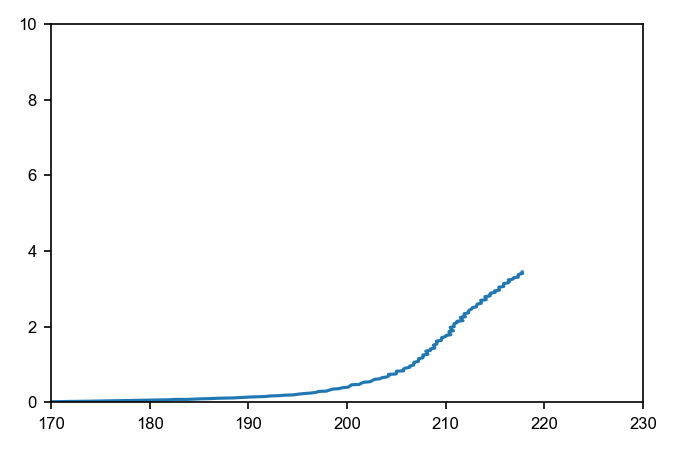

In [175]:
dv  = qc.load_by_id(116)
dv2 = qc.load_by_id(115)

b = np.array(dv.get_data("ivvi_setup_dac1"))[:,0] 
i = np.array(dv.get_values('ivvi_setup_i_measurement'))[:,0]
v = np.array(dv.get_values('ivvi_setup_v_measurement'))[:,0]

R = 13e3 + 2*(5e3  + 1.7e3)
# R = 0
b2, i2, v2 = process_data(b, i, v, R, smooth_win=10)

b3 = np.array(dv2.get_data("ivvi_setup_dac1"))[:,0] 
i3 = np.array(dv2.get_values('ivvi_setup_i_measurement'))[:,0]
v3 = np.array(dv2.get_values('ivvi_setup_v_measurement'))[:,0]

R = 13e3 + 2*(5e3  + 1.7e3)
# R = 0
b4, i4, v4 = process_data(b3, i3, v3, R, smooth_win=10)



fig, ax = plt.subplots(1, 1)

ax.plot(b2, i2)


ax.set_xlim([170, 230])
ax.set_ylim([0, 10])

fig.tight_layout()

0 0 0
0 0 0
[-0.00025937]


<IPython.core.display.Javascript object>


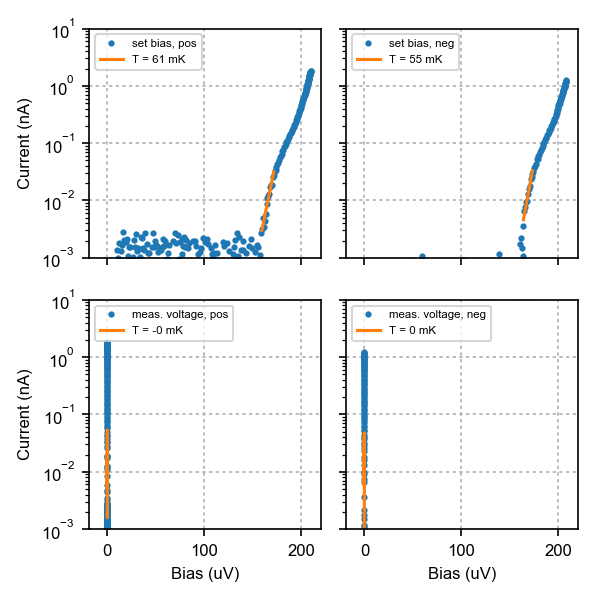

In [191]:
dv = qc.load_by_id(122)

b = np.array(dv.get_data("ivvi_setup_dac1"))[:,0] 
i = np.array(dv.get_values('ivvi_setup_i_measurement'))[:,0]
v = np.array(dv.get_values('ivvi_setup_v_measurement'))[:,0]

R = 13e3 + 2*(5e3  + 1.7e3)
b2, i2, v2 = process_data(b, i, v, R, smooth_win=10)


b_plus = b2[b2.size//2:]
b_minus = -b2[:b2.size//2]
v_plus = v2[v2.size//2:]
v_minus = -v2[:v2.size//2]
i_plus = i2[i2.size//2:]
i_minus = -i2[:i2.size//2]


labels = ['set bias, pos', 'set bias, neg', 'meas. voltage, pos', 'meas. voltage, neg']

fig, axes = plt.subplots(2, 2, figsize=(4, 4), sharex=True, sharey=True)

for i, v, ax, lbl in zip([i_plus, i_minus]*2, [b_plus, b_minus, v_plus, v_minus], axes.reshape(-1), labels):
    fitv, fiti, T = fit_linslope(i, v, ilim=(0.003, .03))
    ax.plot(v, i, 'o', ms=2, label=lbl)
    ax.plot(fitv, fiti, '-', label=f'T = {T*1e3:.0f} mK')
    ax.legend(loc='upper left', fontsize='x-small')
    
    ax.set_yscale('log')
    ax.grid(dashes=[2,2])
    ax.set_ylim([10**-3, 10**1])
    
axes[0,0].set_ylabel('Current (nA)')
axes[1,0].set_ylabel('Current (nA)')
axes[1,0].set_xlabel('Bias (uV)')
axes[1,1].set_xlabel('Bias (uV)')

# fig.suptitle(ds_title(dataid), size='x-small')
fig.tight_layout()

In [ ]:
dv = qc.load_by_id